In [13]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices

In [14]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

In [3]:
data = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv', index_col=0)
labels = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv', index_col=0)

In [15]:
p = 500     # Fix p at something large, e.g. 500 or 1000
n_list = [125, 250, 375]    # Let n vary compared to p, e.g. iterate through [200, 500, 750] if you set p = 1000. What truly matters here is the ratio p / n, so if you choose p differently, adjust your choices for n
sparsities = [0.75, 0.9, 0.95, 0.99]    # Let sparsity vary for a few choices, e.g. [0.75, 0.9, 0.95, 0.99]
SNR = 2     # You can fix SNR at something reasonable like 2 or 5 throughout
beta_scale = 5      # Same holds for beta_scale, maybe 5 or 10
rng = np.random.default_rng(12345)
test_size = 500

Test without varying input parameters

In [29]:
def bootstrap(idx_list, n, x, y):
    bootstrap_idx = choices(idx_list, k=n)
    x_bootstrap = x[bootstrap_idx]
    y_bootstrap = y[bootstrap_idx]

    return x_bootstrap, y_bootstrap

In [66]:
n_folds = 5
n_bootstraps = 100
n_runs = len(n_list)*len(sparsities)
feature_statistics_min = np.zeros((n_runs, p))
feature_statistics_1se = np.zeros((n_runs, p))
true_beta = np.zeros((n_runs, p))

counter = 0
for i, n in enumerate(n_list):
    idx_list = list(range(n))
    for j, sparsity in enumerate(sparsities):
        x, y, beta = simulate_data(n, p, rng, sparsity=sparsity)
        beta = np.where(beta != 0, 1, 0)

        lasso_min = LassoCV(cv=n_folds).fit(x, y)
        alpha_min = lasso_min.alpha_

        # Find alpha_1se
        mse_mat = lasso_min.mse_path_
        cv_mean = np.mean(mse_mat, axis=1)
        cv_std = np.std(mse_mat, axis=1)
        idx_min_mean = np.argmin(cv_mean)
        idx_alpha = np.where(
            (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
            (cv_mean >= cv_mean[idx_min_mean])
        )[0][0]
        alpha_1se = lasso_min.alphas_[idx_alpha]

        for _ in range(n_bootstraps):
            x_sample, y_sample = bootstrap(idx_list, n, x, y)

            lasso_min = Lasso(alpha=alpha_min).fit(x_sample, y_sample)
            lasso_1se = Lasso(alpha=alpha_1se).fit(x_sample, y_sample)

            # Find selected features from models
            lasso_min_beta = np.where(lasso_min.coef_ != 0, 1, 0)
            lasso_1se_beta = np.where(lasso_1se.coef_ != 0, 1, 0)

            # Save feature statistics for each parameter variation
            feature_statistics_min[counter] += lasso_min_beta
            feature_statistics_1se[counter] += lasso_1se_beta

        true_beta[counter] = beta
        counter += 1

Feature histogram

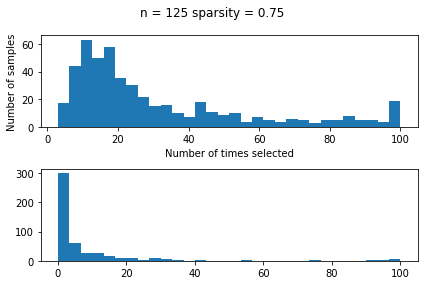

In [74]:
fig, axs = plt.subplots(2)
axs[0].hist(feature_statistics_min[8], bins=30)
axs[0].set_xlabel('Number of times selected')
axs[0].set_ylabel('Number of samples')
axs[1].hist(feature_statistics_1se[5], bins=30)
fig.suptitle(f'n = {n_list[0]} sparsity = {sparsities[0]}')
plt.tight_layout()
plt.show()

Set threshold at 90%

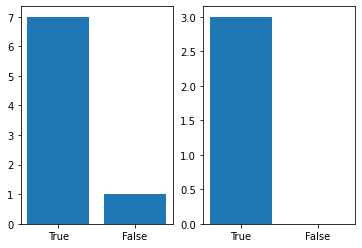

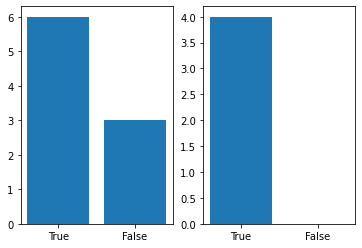

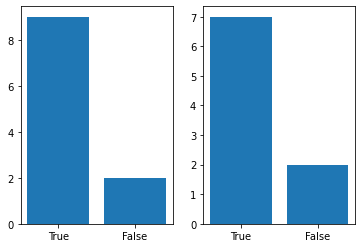

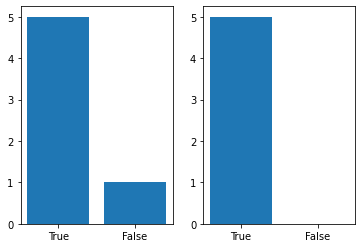

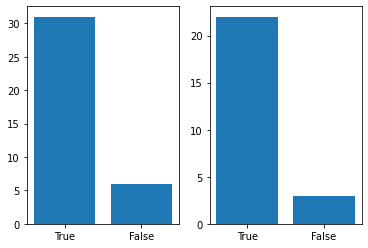

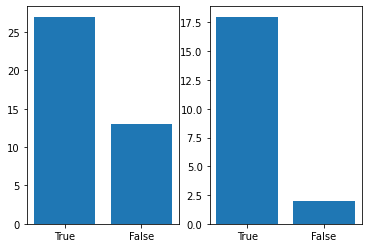

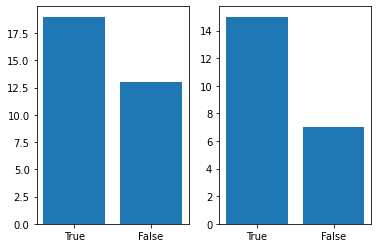

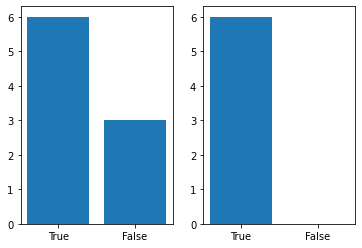

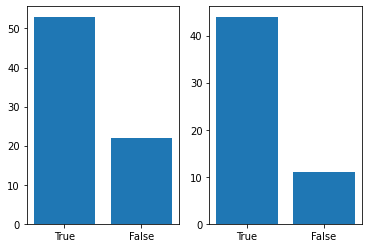

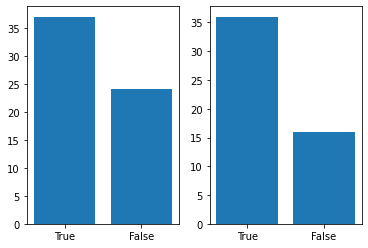

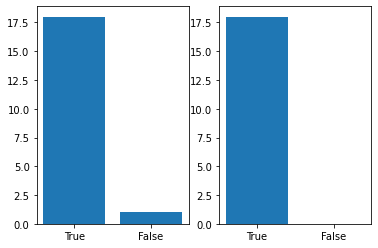

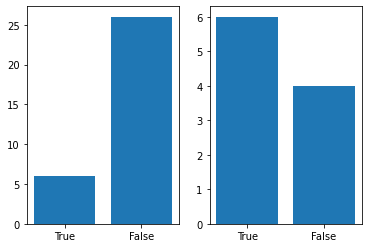

In [68]:
threshold = 60
for features_min, features_1se, beta in zip(feature_statistics_min, feature_statistics_1se, true_beta):
    selected_min = np.where(features_min > threshold, 1, 0)
    selected_1se = np.where(features_1se > threshold, 1, 0)
    
    true_features_min = sum(np.where((selected_min == beta) & (selected_min == 1), 1, 0))
    true_features_1se = sum(np.where((selected_1se == beta) & (selected_1se == 1), 1, 0))

    false_features_min = sum(selected_min) - true_features_min
    false_features_1se = sum(selected_1se) - true_features_1se

    fig, axs = plt.subplots(1,2)
    axs[0].bar(['True', 'False'], [true_features_min, false_features_min])
    axs[1].bar(['True', 'False'], [true_features_1se, false_features_1se])

Question 2

In [75]:
n = 250
sparsity = 99
SNR = 2
rng = np.random.default_rng(12345)
thresholds = [0.4, 0.6, 0.8, 0.9]

In [ ]:
for threshold in thresholds:
    for i in range(100):
        pass